In [1]:
"""
1. 머신러닝 알고리즘 실습 개요
    (1) 알고리즘 선정 이유
        -수집된 데이터의 특징과 상황에 따라 적합한 알고리즘 선택이 중요
        - 이 책에서 다룰 알고리즘(k-최근접 이웃, SVM, 의사결정트리, 랜덤포레스트, 나이브베이즈, 선형회귀, 로지스틱회귀, K평균, 주성분 분석) 각각의 장단점을 파악하는 것이 중요
    
2.k-최근법 이웃(kNN)
    -데이터 분류에 사용되는 아주 간단한 지도학습 알고리즘
    -장점 : 이해하기 쉬움, 별도의 학습이 필요 없음, 숫자로 구분된 속성에 우수한 성능
    -단점 : 연산속도가 느림, 예측값이 지역정보에 많이 편향될 수 있음
    
    (1)[이론]
        - 이웃 : 가까이 존재하는 (값을 알 수 있는) 데이터들
        - 현재 데이터를 특정값으로 분류하기 위해 기존의 데이터 안에서 현재 데이터로부터 가까운 k개의 데이터를 찾아 k개의 레이블 중 가장 많이 분류된 값으로 현재 데이터를 분류하는 알고리즘
        - 이진 분류를 할 때는 과반수의 답을 얻기 위해 k는 홀수로 지정
        - 다중분류에도 활용 가능
        - 벡터 공간 속에서 예측해야 할 데이터와 기존 데이터간의 거리를 계산해서 가장 가까운 이웃부터 k번째 이웃까지 판단, 가장 많이 측정된 레이블로 새로운 데이터를 분류하는 알고리즘 : ||u - v||가 분류 기준이 됨
        -
                
"""

#(2)[실습] 농구선수의 게임 데이터를 활용한 포지션 예측
import pandas as pd
df = pd.read_csv("basketball_stat.csv")
"""
3P : 평균 3점슛 성공횟수
2P : 평균 2점슛 성공횟수
TRB : 평균 리바운드 횟수
AST : 평균 어시스트 성공 횟수
STL : 평균 스틸횟수
BLK : 평균 블로킹 성공횟수
"""
df.Pos.value_counts() #현재 데이터에서 포지션 개수 확인

C     50
SG    50
Name: Pos, dtype: int64

Text(0.5, 1, 'sTL and 2P in plane')

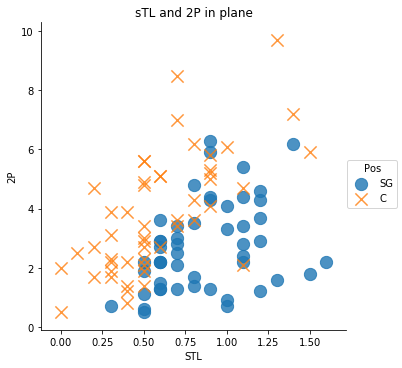

In [6]:
#불필요한 데이터를 가리기 위한 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#스틸, 2점슛 데이터 시각화 
sns.lmplot('STL', '2P', data = df, fit_reg = False, scatter_kws={"s":150}, markers=["o","x"], hue="Pos") # scatter_kws는 좌표상 점의 크기, hue는 예측값
plt.title('STL and 2P in 2d plane')


Text(0.5, 1, 'AST and 2P in plane')

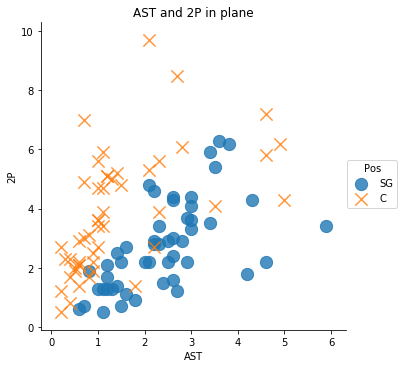

In [7]:
#어시스트, 2점슛 데이터 시각화
sns.lmplot('AST', '2P', data = df, fit_reg = False, scatter_kws={"s":150}, markers=["o","x"], hue="Pos") # scatter_kws는 좌표상 점의 크기, hue는 예측값
plt.title('AST and 2P in 2d plane')

#어시스트, 2점슛, 스틸은 경계가 모호해서 분류기준으로 부적합

Text(0.5, 1, 'BLK and 3P in 2d plane')

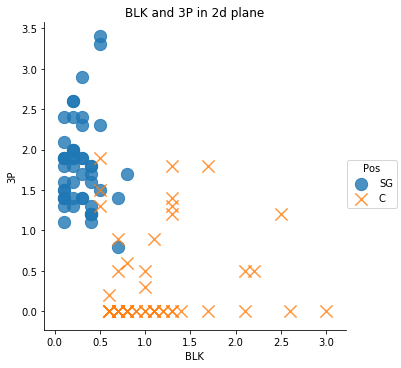

In [8]:
#블로킹, 3점슛 데이터 시각화
sns.lmplot('BLK', '3P', data = df, fit_reg = False, scatter_kws={"s":150}, markers=["o","x"], hue="Pos") # scatter_kws는 좌표상 점의 크기, hue는 예측값
plt.title('BLK and 3P in 2d plane')

Text(0.5, 1, 'TRB and 3P in 2d plane')

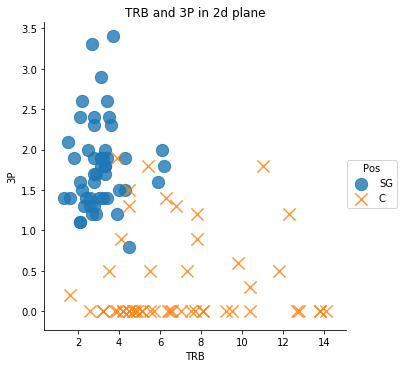

In [9]:
#리바운드, 3점슛 데이터 시각화
sns.lmplot('TRB', '3P', data = df, fit_reg = False, scatter_kws={"s":150}, markers=["o","x"], hue="Pos") # scatter_kws는 좌표상 점의 크기, hue는 예측값
plt.title('TRB and 3P in 2d plane')

#리바운드, 블로킹, 3점슛이 분류기준으로 적합한 것 확인

In [10]:
#데이터 다듬기
df.drop(['2P','AST','STL'], axis=1, inplace=True) #분별력이 없는 특징을 제거

In [14]:
#데이터를 학습할 데이터와 테스트할 데이터로 나누기 -> 사이킷런의 train_test_split 이용
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)
train.shape[0]
test.shape[0] #데이터 개수확인

20

In [17]:
#최적의 kNN 파라미터 찾기 : 에측력이 가장 높은 k 찾기
from sklearn.neighbors import KNeighborsClassifier # kNN라이브러리 호출
from sklearn.model_selection import cross_val_score # k-fold 교차 검증을 위한 라이브러리 호출

#최적의 k를 찾기 위해 교차검증을 수행할 k의 범위를 3부터 학습데이터 절반까지 지정
max_k_range = train.shape[0]//2
k_list = []
for i in range(3, max_k_range, 2):
    k_list.append(i)

cross_validation_scores = []
x_train = train[['3P', 'BLK', 'TRB']]
y_train = train[['Pos']]

#교차 검증(10-fold)을 각 k를 대상으로 수행해 검증 결과를 저장
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train.values.ravel(), cv=10, scoring = 'accuracy') #y_train_values_ravel()은 y_train의 value를 하나의 리스트로 반환
    cross_validation_scores.append(scores.mean())

cross_validation_scores

[0.8746031746031747,
 0.8996031746031747,
 0.8996031746031747,
 0.9121031746031747,
 0.9121031746031747,
 0.9246031746031746,
 0.9246031746031746,
 0.9246031746031746,
 0.9246031746031746,
 0.9121031746031747,
 0.8746031746031747,
 0.8746031746031747,
 0.8746031746031747,
 0.8246031746031747,
 0.8246031746031747,
 0.8246031746031747,
 0.8246031746031747,
 0.8246031746031747,
 0.8246031746031747]

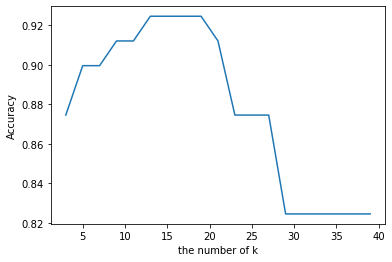

In [21]:
#k에 따른 정확도를 시각화
plt.plot(k_list, cross_validation_scores)
plt.xlabel('the number of k')
plt.ylabel('Accuracy')
plt.show()

In [22]:
#가장 예측률이 높은 k를 선정
k = k_list[cross_validation_scores.index(max(cross_validation_scores))]
print("The best number of k : " + str(k))

The best number of k : 13


In [30]:
#모델 테스트
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=13)

#학습에 사용될 속성을 지정
x_train = train[['3P', 'BLK', 'TRB']]
#선수 포지션을 예측할 값으로 지정
y_train = train[['Pos']]

#knn 모델 학습
knn.fit(x_train, y_train.values.ravel())

#테스트 데이터에서 분류를 위해 사용될 속성 지정
x_test = test[['3P', 'BLK', 'TRB']]
#선수 포지션에 대한 정답을 지정
y_test = test[['Pos']]

#테스트 시작
pred = knn.predict(x_test)

#모델 예측 정확도(accuracy) 출력
print("accuracy : " + str(accuracy_score(y_test.values.ravel(), pred)))

accuracy : 0.9


In [31]:
#실제값과 예측값을 비굫려면
comparison = pd.DataFrame({'prediction':pred, 'ground_truth':y_test.values.ravel()})
comparison

,ground_truth,prediction
0,SG,SG
1,C,C
2,C,C
3,SG,SG
4,SG,SG
5,SG,SG
6,C,C
7,SG,SG
8,C,SG
9,C,C


In [57]:
"""
3. 서포트 벡터 머신(SVM)
    -사용하기 편하면서 높은 정확성을 보이는 지도학습 머신러닝
    
    (1) [이론]
        - 서포트 벡터는 데이터를 구분하는 경계선과 가장 가까이 맞닿은 데이터 포인트를 의미
        (i) 마진
            - 서포트 벡터와 경계선 사이의 거리를 '마진'이라고 하는데, SVM의 목표는 마진을 최대로 하는 결정 경계를 찾는 것
            - 마진이 크다 = 우리가 현재 알지 못하는 새로운 데이터를 안정적으로 분류할 가능성이 높다
       
        (ii) 비용
            - 약간의 오차가 있어도 마진이 큰 모델이 좋은 모델이기 때문에 SVM에서는 약간의 오류를 허용하기 위해 '비용' 이라는 변수 활용
            - 비용이 낮을 수록 마진을 최대한 높이고, 학습 에러율을 증가하는 방향으로 결정 경계선 생성 ; 비용이 높을 땐 반대
            - 비용이 너무 낮으면 과소적합 문제, 너무 높으면 과대적합 위험 발생 -> 적절한 비용값을 찾는 과정이 중요
        
        (iii) 결정경계
            - 결정경계는 데이터의 공간이 N차원일 경우 N-1차원으로 정해짐 -> 이러한 이유로 결정경계를 초평면이라고 부르기도 함
            - 차원이 낮을 경우 결정경계를 찾기 힘들 기 때문에 저차원->고차원으로 옮기는 방식을 이용, 이때 저차원 데이터를 고차원으로 옮겨주는 함수를 '매핑함수'
        
        (iv) 커널트릭
            - 실제로 많은 양의 데이터를 저차원에서 고차원으로 옮기기는 쉽지않음 -> 실제로 데이터의 차원을 옮기진 않지만 옮긴것과 동일한 효과를 줘서 빠르게 결정 경계를 찾는 방법이 '커널트릭'
            - ex) 2차원의 공간에서 직선이 아닌 결정 경계선으로 데이터를 분류
            - 커널 기법의 종류는 다양하지만 이번 장에서는 가우시안 RBF커널 이용
            - 가우시안 RBF커널은 데이터 포인트에 적용되는 가우시안 함수의 표준편차를 조정함으로써 결정 경계의 곡률 조정, 이때 표준편차 조정 변수를 감마(gamma)라고 부름
        
        (v) 파라미터 튜닝
            - SVM에서 정확도를 높이기 위해 조절 가능한 파라미터는 비용과 감마
        
        (vi) 장점과 단점
            - 장점 : 커널트릭을 이용, 특성이 다양한 데이터 분류 가능 / 파라미터 조정을 통해 과적합문제 대처가능 / 적은 학습데이터로도 정확도가 높은 분류 기대 가능
            - 단점 : 데이터 전처리 과정이 상당히 중요, 특성이 다양하거나 확연히 다른 경우 전처리를 통해 데이터의 특성 그대로 벡터 공간에 표현해야 함 / 특성이 많을 경우 결정 경계 및 데이터 시각화가 어려움
"""

# [실습] 농구선수의 게임 기로글 학습해서 포지션을 예측
#최적의 SVM 파라미터 찾기 -> 최적의 비용과 감마를 사이킷런의 gridsearch를 이용하면 간편하게 찾아낼 수 있음
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import numpy as np

#최적의 비용과 감마 도출
def svc_param_selection(X, y, nfolds):
    svm_parameters = [
        {'kernel': ['rbf'],
        'gamma' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
        'C' : [0.01, 0.1, 1, 10, 100, 1000]}
    ]
    #사이킷런에서 제공하는 GridSearchCV를 사용, 최적의 파라미터를 구함
    clf = GridSearchCV(SVC(), svm_parameters, cv=10)
    clf.fit(X_train, y_train.values.ravel())
    print(clf.best_params_)
    
    return clf

#3점슛과 블로킹 횟수를 학습 데이터로 사용
X_train = train[['3P','BLK']]

#농구선수 포지션을 예측값으로 선정
y_train = train[['Pos']]

#최적의 파라미터로 학습된 모델을 clf로 저장
clf = svc_param_selection(X_train, y_train.values.ravel(),10)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


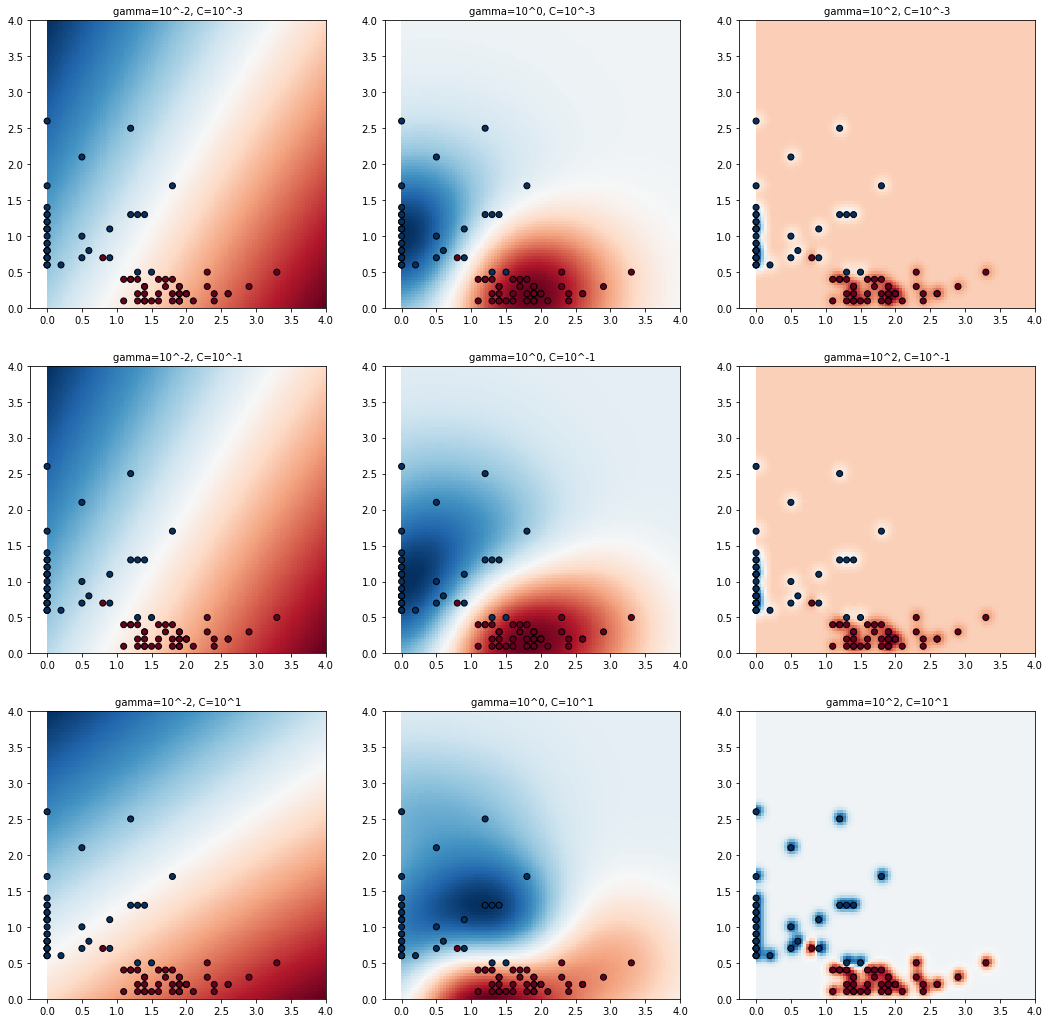

In [58]:
#결정 경계선 시각화

#시각화할 비용 후보들을 저장
C_candidates = []
C_candidates.append(clf.best_params_['C'] * 0.01)
C_candidates.append(clf.best_params_['C'])
C_candidates.append(clf.best_params_['C'] * 100)

#시각화할 감마 후보들 저장
gamma_candidates = []
gamma_candidates.append(clf.best_params_['gamma'] * 0.01)
gamma_candidates.append(clf.best_params_['gamma'])
gamma_candidates.append(clf.best_params_['gamma'] * 100)

#3점슛과 블로킹 횟수로 학습
X = train[['3P','BLK']]

#포지션을 분류값으로 사용
Y = train['Pos'].tolist() #리스트로 변환

#시각화를 위해 센터와 슈팅가드를 숫자로 표현
position = []
for gt in Y:
    if  gt == 'C':
        position.append(0)
    else:
        position.append(1)

classifiers = []

#파라미터 후보들을 조합해서 학습된 모델들을 저장
for C in C_candidates:
    for gamma in gamma_candidates:
        clf = SVC(C=C, gamma = gamma) #순서는 모델을 변수에 할당 -> 변수.fit(학습데이터) -> 변수.predict(테스트데이터) 가 보통인듯
        clf.fit(X,Y)
        classifiers.append((C, gamma, clf))

#각 모델을 시각화
plt.figure(figsize = (18,18))
xx, yy = np.meshgrid(np.linspace(0,4,100), np.linspace(0,4,100)) # 좌표계를 반납, 0부터 4까지 100으로 나눈 값들, square matrix로 반환

for (k, (C, gamma, clf)) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) #np.c_[]는 n by 1 벡터로 반환, clf.decision_function()는 해당 좌표 상에서 결정경계를 반납하는 듯
    Z = Z.reshape(xx.shape)
    
    plt.subplot(len(C_candidates), len(gamma_candidates), k+1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)), size = 'medium')
    
    plt.pcolormesh(xx,yy,-Z, cmap = plt.cm.RdBu) # -Z를 해야 생상이 올바르게 배치( +Z하면 반대로 배치)
    plt.scatter(X['3P'], X['BLK'], c = position, cmap = plt.cm.RdBu_r, edgecolors='k')

In [60]:
#모델 테스트
X_test = test[['3P','BLK']]
y_test = test[['Pos']]

y_true, y_pred = y_test, clf.predict(X_test)

print(classification_report(y_true, y_pred))
print()
print("accuracy : " + str(accuracy_score(y_true, y_pred)))

             precision    recall  f1-score   support

          C       0.78      0.64      0.70        11
         SG       0.64      0.78      0.70         9

avg / total       0.71      0.70      0.70        20


accuracy : 0.7


In [61]:
comparison = pd.DataFrame({'prediction' : y_pred, 'ground_truth' : y_true.values.ravel()})
comparison

,ground_truth,prediction
0,SG,SG
1,C,SG
2,C,SG
3,SG,C
4,SG,SG
5,SG,SG
6,C,SG
7,SG,SG
8,C,C
9,C,C
